#### AI/ML directed high-throughput virtual screening of probes to selectively bind with PFOS using SDS as interferent
#### Siva Dasetty, Max Topel | Ferguson Lab


## imports

In [1]:
import os
import os.path
import sys
import importlib
import yaml

import subprocess

from time import time
from datetime import datetime

import numpy as np
import pandas as pd
import math

import scipy

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import Descriptors
from rdkit.Chem.Fragments import *

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from matplotlib import rcParams
import matplotlib as mpl
from matplotlib  import cm
from PIL import Image
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data

import multiprocessing

from sklearn.metrics import mean_squared_error

sys.path.append("/home/sivadasetty/scratch-midway2/pfas/analysis/NB_PFAS/activeLearning/codes/")


import utils_activeLearning_Oliver as ut

import utils_functions as utils_functions
import utils_figures as utils_figures

importlib.reload(ut)
importlib.reload(utils_functions)
importlib.reload(utils_figures)

import selfies as sf

sys.path.append("../activeLearning")
from oliver_vae.VAE import VAE_encode, VAE_decode

import torch
from torch import nn

import copy

import oapackage


#sys.path.append("/project2/andrewferguson/maxtopel/pfas/Codes")
sys.path.append("/project2/andrewferguson/sivadasetty/pfas/analysis/NB_PFAS/Codes")

import importlib
import calculateFES
importlib.reload(calculateFES)


<module 'calculateFES' from '/project2/andrewferguson/sivadasetty/pfas/analysis/NB_PFAS/Codes/calculateFES.py'>

## plot settings

In [2]:
plt.rcParams.update({'font.size': 30})

# time stamp
now = datetime.now()
now = str(now)[:10]
figures_dir = './Manuscript_Figures_JCED/{}'.format(str(now)).replace(':','-')

#### extract delta G and Kb from newly computed data

In [3]:
#### read previously computed and newly computed delta G data

simdir = '/project2/andrewferguson/sivadasetty/pfas/'


new_Kb_data_cycle_PFOS = []
new_Kb_data_cycle_PFOS_SD = []
new_Kb_data_cycle_SDS = []
new_Kb_data_cycle_SDS_SD = []

new_deltaG_data_cycle_PFOS = []
new_deltaG_data_cycle_PFOS_SD = []
new_deltaG_data_cycle_SDS = []
new_deltaG_data_cycle_SDS_SD = []

smiles_cycle = []

for analyte in ['PFOS', 'SDS']:
    
    for c in range(0,11):
        
        
        new_deltaG_data = pd.read_csv(simdir+'/analysis/NB_PFAS/MS_Figs/kb_deltaGRepeated_JCED/wsmiles_deltaG-linearProbesBlockArea-b3-pbmd-4cvs_cycle_'+str(c)+'.txt', delim_whitespace=True, 
                              names=["Method", "Analyte", "lprobe", "lflourines", "lhydrogen", "hhydrogen", 
                                     "hcarbons", "Probe", "Avg", "SD", "smiles", "formula"], comment="#")

        if analyte == 'PFOS':
            new_deltaG_data_cycle_PFOS.append(new_deltaG_data[(new_deltaG_data["Analyte"] == analyte)].Avg.values)
            new_deltaG_data_cycle_PFOS_SD.append(new_deltaG_data[(new_deltaG_data["Analyte"] == analyte)].SD.values)
        else:
            new_deltaG_data_cycle_SDS.append(new_deltaG_data[(new_deltaG_data["Analyte"] == analyte)].Avg.values)
            new_deltaG_data_cycle_SDS_SD.append(new_deltaG_data[(new_deltaG_data["Analyte"] == analyte)].SD.values)
                    
        new_Kb_data = pd.read_csv(simdir+'/analysis/NB_PFAS/MS_Figs/kb_deltaGRepeated_JCED/wsmiles_Kb-linearProbesBlockArea-b3-pbmd-4cvs_cycle_'+str(c)+'.txt', delim_whitespace=True, 
                              names=["Method", "Analyte", "lprobe", "lflourines", "lhydrogen", "hhydrogen", 
                                     "hcarbons", "Probe", "Avg", "SD", "smiles", "formula"], comment="#")

        if analyte == 'PFOS':
            new_Kb_data_cycle_PFOS.append(new_Kb_data[(new_Kb_data["Analyte"] == analyte)].Avg.values)
            new_Kb_data_cycle_PFOS_SD.append(new_Kb_data[(new_Kb_data["Analyte"] == analyte)].SD.values)
            smiles_cycle.append(new_Kb_data[(new_Kb_data["Analyte"] == analyte)].smiles.values)
        else:
            new_Kb_data_cycle_SDS.append(new_Kb_data[(new_Kb_data["Analyte"] == analyte)].Avg.values)
            new_Kb_data_cycle_SDS_SD.append(new_Kb_data[(new_Kb_data["Analyte"] == analyte)].SD.values)
                    
            
            
        
    

#### kb based sensitivity and selectivity calculation

In [4]:
cycles=11

sensitivity_cycle = []
sensitivity_cycle_SD = []
sds_sensitivity_cycle = []
sds_sensitivity_cycle_SD = []
selectivity_cycle = []
selectivity_cycle_SD = []

kT = 1 #300*0.008314
for c in range(cycles):

    sensitivity_cycle.append(-np.array(new_deltaG_data_cycle_PFOS[c]).flatten()/kT)
    sensitivity_cycle_SD.append(np.array(new_deltaG_data_cycle_PFOS_SD[c]).flatten()/kT)

    sds_sensitivity_cycle.append(-np.array(new_deltaG_data_cycle_SDS[c]).flatten()/kT)
    sds_sensitivity_cycle_SD.append(np.array(new_deltaG_data_cycle_SDS_SD[c]).flatten()/kT)
    
    selectivity = np.array(new_deltaG_data_cycle_PFOS[c]).flatten() - np.array(new_deltaG_data_cycle_SDS[c]).flatten()
    selectivityError = np.sqrt(np.array(new_deltaG_data_cycle_PFOS_SD[c]).flatten()**2 + np.array(new_deltaG_data_cycle_SDS_SD[c]).flatten()**2)
    
    selectivity_cycle.append(-selectivity/kT)
    selectivity_cycle_SD.append(selectivityError)
    
catenated_sensitivity = []
catenated_sensitivity_SD = []
catenated_SDS_sensitivity = []
catenated_SDS_sensitivity_SD = []
catenated_selectivity = []
catenated_selectivity_SD = []

catenated_smiles = []
for c in range(cycles):
    
    _temp = sensitivity_cycle[c]
    _temp_SD = sensitivity_cycle_SD[c]
    _temp_SDS = sds_sensitivity_cycle[c]
    _temp_SDS_SD = sds_sensitivity_cycle_SD[c]
    _temp_selectivity = selectivity_cycle[c]
    _temp_selectivity_SD = selectivity_cycle_SD[c]
    _temp_smiles = smiles_cycle[c]
    for k in range(c):
        _temp = np.append(_temp, sensitivity_cycle[k])
        _temp_SD = np.append(_temp_SD, sensitivity_cycle_SD[k])
        _temp_SDS = np.append(_temp_SDS, sds_sensitivity_cycle[k])
        _temp_SDS_SD = np.append(_temp_SDS_SD, sds_sensitivity_cycle_SD[k])
        _temp_selectivity = np.append(_temp_selectivity, selectivity_cycle[k])
        _temp_selectivity_SD = np.append(_temp_selectivity_SD, selectivity_cycle_SD[k])
        _temp_smiles = np.append(_temp_smiles, smiles_cycle[k])
        
        #catenated_sensitivity.append(sensitivity_cycle[k])
        #print(c,k)
     
    catenated_sensitivity.append(_temp)
    catenated_sensitivity_SD.append(_temp_SD)
    catenated_SDS_sensitivity.append(_temp_SDS)
    catenated_SDS_sensitivity_SD.append(_temp_SDS_SD)
    catenated_selectivity.append(_temp_selectivity)
    catenated_selectivity_SD.append(_temp_selectivity_SD)
    catenated_smiles.append(_temp_smiles)


kb_sensitivity_cycle = []
kb_sensitivity_cycle_SD = []
sds_kb_sensitivity_cycle = []
sds_kb_sensitivity_cycle_SD = []
kb_selectivity_cycle = []
kb_selectivity_cycle_SD = []

kT = 1 #300*0.008314
for c in range(cycles):

    kb_sensitivity_cycle.append(np.array(new_Kb_data_cycle_PFOS[c]).flatten())
    kb_sensitivity_cycle_SD.append(np.array(new_Kb_data_cycle_PFOS_SD[c]).flatten())
    
    sds_kb_sensitivity_cycle.append(np.array(new_Kb_data_cycle_SDS[c]).flatten())
    sds_kb_sensitivity_cycle_SD.append(np.array(new_Kb_data_cycle_SDS_SD[c]).flatten())
    
    kb_selectivity = np.array(new_Kb_data_cycle_PFOS[c]).flatten()/np.array(new_Kb_data_cycle_SDS[c]).flatten()
    
    delta_x = new_Kb_data_cycle_PFOS_SD[c]
    x = new_Kb_data_cycle_PFOS[c]
    delta_y = new_Kb_data_cycle_SDS_SD[c]
    y = new_Kb_data_cycle_SDS[c]
    kb_selectivityError = kb_selectivity * np.sqrt((delta_x/x)**2 + (delta_y/y)**2)
    
    kb_selectivity_cycle.append(kb_selectivity)
    kb_selectivity_cycle_SD.append(kb_selectivityError)
    

catenated_kb_sensitivity = []
catenated_kb_sensitivity_SD = []
catenated_kb_sensitivity_SDS = []
catenated_kb_sensitivity_SDS_SD = []
catenated_kb_selectivity = []
catenated_kb_selectivity_SD = []
for c in range(cycles):
    
    _kb_temp = kb_sensitivity_cycle[c]
    _kb_temp_SD = kb_sensitivity_cycle_SD[c]
    _kb_temp_SDS = sds_kb_sensitivity_cycle[c]
    _kb_temp_SDS_SD = sds_kb_sensitivity_cycle_SD[c]
    _kb_temp_selectivity = kb_selectivity_cycle[c]
    _kb_temp_selectivity_SD = kb_selectivity_cycle_SD[c]
    for k in range(c):
        _kb_temp = np.append(_kb_temp, kb_sensitivity_cycle[k])
        _kb_temp_SD = np.append(_kb_temp_SD, kb_sensitivity_cycle_SD[k])
        _kb_temp_SDS = np.append(_kb_temp_SDS, sds_kb_sensitivity_cycle[k])
        _kb_temp_SDS_SD = np.append(_kb_temp_SDS_SD, sds_kb_sensitivity_cycle_SD[k])
        _kb_temp_selectivity = np.append(_kb_temp_selectivity, kb_selectivity_cycle[k])
        _kb_temp_selectivity_SD = np.append(_kb_temp_selectivity_SD, kb_selectivity_cycle_SD[k])
        
        #catenated_sensitivity.append(sensitivity_cycle[k])
        #print(c,k)
     
    catenated_kb_sensitivity.append(_kb_temp)
    catenated_kb_sensitivity_SD.append(_kb_temp_SD)
    catenated_kb_sensitivity_SDS.append(_kb_temp_SDS)
    catenated_kb_sensitivity_SDS_SD.append(_kb_temp_SDS_SD)
    catenated_kb_selectivity.append(_kb_temp_selectivity)
    catenated_kb_selectivity_SD.append(_kb_temp_selectivity_SD)
    

In [5]:
#plt.errorbar(catenated_kb_selectivity,catenated_kb_selectivity_SD)

#### probes on Pareto frontier in the final round

cycle: 0: 2: 0:
Pareto: 8 optimal values, 8 objects
cycle: 1: 2: 1:
cycle: 1
Pareto: 7 optimal values, 7 objects
cycle: 2: 2: 2:
cycle: 2
Pareto: 3 optimal values, 3 objects
cycle: 3: 2: 3:
cycle: 3
Pareto: 3 optimal values, 3 objects
cycle: 4: 2: 4:
cycle: 4
Pareto: 3 optimal values, 3 objects
cycle: 5: 2: 5:
cycle: 5
Pareto: 3 optimal values, 3 objects
cycle: 6: 3: 0:
cycle: 6
Pareto: 4 optimal values, 4 objects
cycle: 7: 3: 1:
cycle: 7
Pareto: 4 optimal values, 4 objects
cycle: 8: 3: 2:
cycle: 8
Pareto: 4 optimal values, 4 objects
cycle: 9: 3: 3:
cycle: 9
Pareto: 5 optimal values, 5 objects
cycle: 10: 3: 4:
cycle: 10
Pareto: 5 optimal values, 5 objects
cycle:10

[93, 100, 147, 182, 251]


<Figure size 700x400 with 0 Axes>

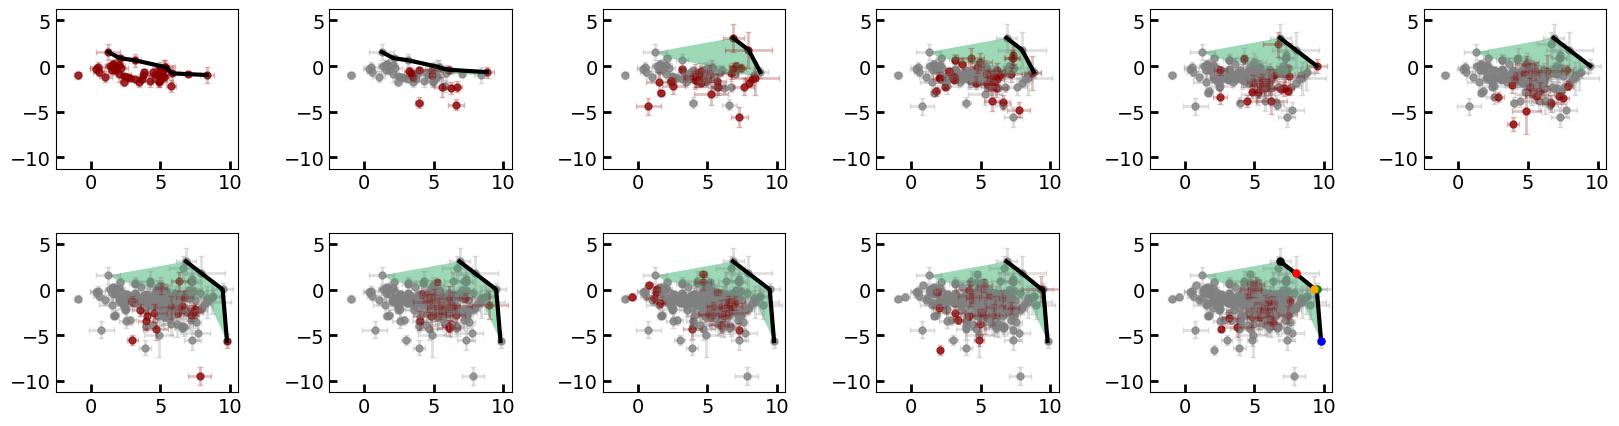

In [6]:
##############################################################################################################################################            

labelfont=20
tickfont=18
legendfont=8

import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=([7,4]))

#gs = gridspec.GridSpec(2,6)
#gs.update(wspace=1.5, hspace=0.3)

fig = plt.figure(figsize=[20,10])
fig.tight_layout(pad=100.0)
spec = gridspec.GridSpec(ncols=6, nrows=4)
fig.subplots_adjust(bottom=0.05, hspace=.4, wspace=.5)

ax = ['ax1', 'ax2', 'ax3', 'ax4', 'ax5', 'ax6', 'ax7', 'ax8', 'ax9', 'ax10', 'ax11', 'ax12', 'ax13', 'ax14']


kT = 1 #300*0.008314
    
##############################################################################################################################################            
mean_distance_all = []
mean_distance_pareto_only = []    
##############################################################################################################################################            
col=0
row=2
for c in range(11):
    
    tickfont=14
    
    if c!=0:
        if c % 6 == 0:
            col = 0
            row += 1
        else:
            col += 1
    
    print("cycle: %d: %d: %d:"% (c, row, col))
    
    #ax[c] = fig.add_subplot(2, 6, c+3)
    pc = c+2
    ax[pc] = fig.add_subplot(spec[row, col])
    ax[pc].tick_params(axis="x", labelsize=tickfont, direction='in', length=6, width=2, colors='black', rotation=0)
    ax[pc].tick_params(axis="y", labelsize=tickfont, direction='in', length=6, width=2, colors='black')
    ax[pc].tick_params(which='minor', direction='in', length=3, width=2)
    #spec.update(wspace=0.45, hspace=0.7)
    
    if c == 11:
        ax[pc].axis('off')
        
    
    for k in range(c):
        ax[pc].scatter(sensitivity_cycle[k], selectivity_cycle[k], 
                      color="gray", s=25, alpha=0.75, marker='o', label='init')
    
        ax[pc].errorbar(sensitivity_cycle[k], selectivity_cycle[k], 
                       xerr= sensitivity_cycle_SD[k], yerr= selectivity_cycle_SD[k], 
                        color="gray", ms=25, alpha=0.25, elinewidth=2, capsize=2, lw=0)
    
    ax[pc].scatter(sensitivity_cycle[c], selectivity_cycle[c], 
                  color="darkred", s=25, alpha=0.75, marker='o', label='init')
    
    ax[pc].errorbar(sensitivity_cycle[c], selectivity_cycle[c],
                   xerr= sensitivity_cycle_SD[c], yerr= selectivity_cycle_SD[c], 
                    color="darkred", ms=25, alpha=0.25, elinewidth=2, capsize=2, lw=0)

    pareto=oapackage.ParetoDoubleLong()
    for ii in range(0, catenated_sensitivity[0].shape[0]):
        
        w=oapackage.doubleVector( (catenated_sensitivity[0][ii], catenated_selectivity[0][ii]))
        
        pareto.addvalue(w, ii)
    
    lst_init=pareto.allindices() # the indices of the Pareto optimal designs

    init_Pareto_sensitivity = catenated_sensitivity[0][list(lst_init)]
    init_Pareto_selectivity = catenated_selectivity[0][list(lst_init)]
    arg_sort_list = np.argsort(init_Pareto_sensitivity)
    init_Pareto_sensitivity = init_Pareto_sensitivity[arg_sort_list]
    init_Pareto_selectivity = init_Pareto_selectivity[arg_sort_list]

    
    
    if c == 0:
        
        sensitivity = catenated_sensitivity[0]
        selectivity = catenated_selectivity[0]
        
        
        Pareto_sensitivity = init_Pareto_sensitivity
        Pareto_selectivity = init_Pareto_selectivity
        
        pareto.show(verbose=1)
        
    else:
        # current
        print("cycle: %d" % c)
        
        sensitivity = catenated_sensitivity[c]
        selectivity = catenated_selectivity[c]
        
        pareto=oapackage.ParetoDoubleLong()
        for ii in range(0, catenated_sensitivity[c].shape[0]):
            
            w=oapackage.doubleVector( (catenated_sensitivity[c][ii],catenated_selectivity[c][ii]) )
            
            pareto.addvalue(w, ii)

        pareto.show(verbose=1)

        lst=pareto.allindices() # the indices of the Pareto optimal designs
        
        Pareto_sensitivity = catenated_sensitivity[c][list(lst)]
        Pareto_selectivity = catenated_selectivity[c][list(lst)]
        arg_sort_list = np.argsort(Pareto_sensitivity)[::-1] # reverse for proper green shade fill
        Pareto_sensitivity = Pareto_sensitivity[arg_sort_list]
        Pareto_selectivity = Pareto_selectivity[arg_sort_list]
        
        
        ax[pc].fill(np.append(init_Pareto_sensitivity,Pareto_sensitivity), 
                   np.append(init_Pareto_selectivity,Pareto_selectivity), 'mediumseagreen', alpha=0.5)
        
        if c==10:
            print(f"cycle:{c}\n")
            final_round_Pareto_catenated_indices = list(lst)
            print(final_round_Pareto_catenated_indices)

    
    ax[pc].plot(Pareto_sensitivity,Pareto_selectivity, color="black", alpha=1, ms=0, marker='o', lw=3)
    
    if c==10:
        colors=['blue', 'green', 'orange', 'red', 'black']
        for m in range(Pareto_sensitivity.shape[0]):
            ax[pc].plot(Pareto_sensitivity[m],Pareto_selectivity[m], c=colors[m], alpha=1, ms=5, marker='o', lw=3)
        
    #ax[pc].scatter(Pareto_sensitivity,Pareto_selectivity, color="black", alpha=1, s=20, marker='o', lw=3)
    


    lkT=300*0.008314
    ax[pc].set_xlim(-1*lkT, 4.25*lkT)
    ax[pc].set_ylim(-4.5*lkT, 2.5*lkT)


#### final round Pareto frontier deltaG and Kb based sensitivity and selectivity

In [7]:
final_round_Pareto_catenated_indices
print(f"deltaG sensitivity is {np.round(catenated_sensitivity[10][final_round_Pareto_catenated_indices],3)}+/-{np.round(catenated_sensitivity_SD[10][final_round_Pareto_catenated_indices],3)}")
print(f"deltaG sensitivity is {np.round(catenated_sensitivity[10][final_round_Pareto_catenated_indices],1)}+/-{np.round(catenated_sensitivity_SD[10][final_round_Pareto_catenated_indices],1)}")

print("\n")

print(f"SDS deltaG sensitivity is {np.round(catenated_SDS_sensitivity[10][final_round_Pareto_catenated_indices],3)}+/-{np.round(catenated_SDS_sensitivity_SD[10][final_round_Pareto_catenated_indices],3)}")
print(f"SDS deltaG sensitivity is {np.round(catenated_SDS_sensitivity[10][final_round_Pareto_catenated_indices],1)}+/-{np.round(catenated_SDS_sensitivity_SD[10][final_round_Pareto_catenated_indices],1)}")

print("\n")

print(f"deltaG selectivity is {np.round(catenated_selectivity[10][final_round_Pareto_catenated_indices],3)}+/-{np.round(catenated_selectivity_SD[10][final_round_Pareto_catenated_indices],3)}")
print(f"deltaG selectivity is {np.round(catenated_selectivity[10][final_round_Pareto_catenated_indices],1)}+/-{np.round(catenated_selectivity_SD[10][final_round_Pareto_catenated_indices],1)}")

print("\n")

print(f"Kb sensitivity is {np.round(catenated_kb_sensitivity[10][final_round_Pareto_catenated_indices],3)}+/-{np.round(catenated_kb_sensitivity_SD[10][final_round_Pareto_catenated_indices],3)}")
print(f"Kb sensitivity is {np.round(catenated_kb_sensitivity[10][final_round_Pareto_catenated_indices],1)}+/-{np.round(catenated_kb_sensitivity_SD[10][final_round_Pareto_catenated_indices],1)}")

print("\n")

print(f"SDS Kb sensitivity is {np.round(catenated_kb_sensitivity_SDS[10][final_round_Pareto_catenated_indices],3)}+/-{np.round(catenated_kb_sensitivity_SDS_SD[10][final_round_Pareto_catenated_indices],3)}")
print(f"SDS Kb sensitivity is {np.round(catenated_kb_sensitivity_SDS[10][final_round_Pareto_catenated_indices],1)}+/-{np.round(catenated_kb_sensitivity_SDS_SD[10][final_round_Pareto_catenated_indices],1)}")

print("\n")

print(f"Kb selectivity is {np.round(catenated_kb_selectivity[10][final_round_Pareto_catenated_indices],3)}+/-{np.round(catenated_kb_selectivity_SD[10][final_round_Pareto_catenated_indices],3)}")
print(f"Kb selectivity is {np.round(catenated_kb_selectivity[10][final_round_Pareto_catenated_indices],1)}+/-{np.round(catenated_kb_selectivity_SD[10][final_round_Pareto_catenated_indices],1)}")


print("\n")

print(f"SMILES is {catenated_smiles[10][final_round_Pareto_catenated_indices]}")




deltaG sensitivity is [7.957 6.851 9.484 9.795 9.312]+/-[1.689 0.751 0.733 0.214 1.373]
deltaG sensitivity is [8.  6.9 9.5 9.8 9.3]+/-[1.7 0.8 0.7 0.2 1.4]


SDS deltaG sensitivity is [ 6.179  3.776  9.478 15.442  9.224]+/-[0.945 1.309 0.018 0.704 0.362]
SDS deltaG sensitivity is [ 6.2  3.8  9.5 15.4  9.2]+/-[0.9 1.3 0.  0.7 0.4]


deltaG selectivity is [ 1.778  3.076  0.006 -5.647  0.088]+/-[1.935 1.509 0.734 0.736 1.42 ]
deltaG selectivity is [ 1.8  3.1  0.  -5.6  0.1]+/-[1.9 1.5 0.7 0.7 1.4]


Kb sensitivity is [ 98.967  62.683 118.349 177.355 129.738]+/-[67.598 15.287 20.752 12.716 45.597]
Kb sensitivity is [ 99.   62.7 118.3 177.4 129.7]+/-[67.6 15.3 20.8 12.7 45.6]


SDS Kb sensitivity is [  47.895   13.637  106.19  1119.916  118.498]+/-[ 14.664   3.819   1.988 310.229  16.061]
SDS Kb sensitivity is [  47.9   13.6  106.2 1119.9  118.5]+/-[ 14.7   3.8   2.  310.2  16.1]


Kb selectivity is [2.066 4.597 1.114 0.158 1.095]+/-[1.547 1.707 0.197 0.045 0.412]
Kb selectivity is [2.1 4.6

In [ ]:
#### create a pandas dataframe and a latex table

In [8]:
simdir='/project2/andrewferguson/sivadasetty/pfas/'

each_cycle_data = []
for c in range(11):
    
    #each_cycle_data[c].to_csv(simdir+'/analysis/NB_PFAS/MS_Figs/data-each-cycle-JCED/mw_cas_iupac/cycle-'+str(c)+'.txt',sep='\t')
    each_cycle_data.append(pd.read_csv(simdir+'/analysis/NB_PFAS/MS_Figs/data-each-cycle-JCED/mw_cas_iupac/cycle-'+str(c)+'.txt',sep='\t'))
  


each_cycle_data = []

for c in range(11):
    each_cycle_data.append(pd.read_csv(simdir+'/analysis/NB_PFAS/MS_Figs/data-each-cycle-JCED/mw_cas_iupac/cycle-'+str(c)+'.txt',sep='\t'))
    
    nwaters = pd.read_csv(simdir+'/analysis/NB_PFAS/MS_Figs/data-each-cycle-JCED/folder-pdb-each-cycle/jcycle-water-'+str(c)+'.txt',sep='\t', header=None,
                          names=['index', 'pdb', 'smiles', 'PFOS_nwater', 'SDS_nwater', 'PFOS_nbox', 'SDS_nbox'] )
    
    
    #print(nwaters)
    print(nwaters.shape, each_cycle_data[c].shape)
    _nwaters = []
    _box = []
    _structs = []
    _smiles = []
    _iupac = []
    _mw = []
    _sds_sensitivity = []
    _kb_sds_sensitivity = []
    _smiles_string = []
    for j in range(nwaters.shape[0]):
        _nwaters.append( str(nwaters.iloc[j]['PFOS_nwater']) + ',' + str(nwaters.iloc[j]['SDS_nwater']) )
        _box.append( str(nwaters.iloc[j]['PFOS_nbox']) + ',' + str(nwaters.iloc[j]['SDS_nbox']) )
        
        __struct = '\\' + 'begin{minipage}[t]{1\\'+ 'linewidth} ' 
        __struct += '\includegraphics[angle=-45,width=\\textwidth]{./data-each-cycle-JCED/smiles-each-cycle/cycle_'+str(c)+'/struct_'+str(j)+'.png}'
        __struct += ' \\end{minipage}' 
    
        _structs.append(__struct)
        
        #_smiles.append('\seqsplit{' + each_cycle_data[c].iloc[j]['Probe SMILES'] + '}')
        _smiles.append('\seqsplit{' + nwaters.iloc[j]['smiles'] + '}')
        #_smiles.append( nwaters.iloc[j]['smiles'] )
        
        _iupac.append('\seqsplit{' + each_cycle_data[c].iloc[j]['IUPAC'] + '}')
        
        _mw.append(str(np.round(each_cycle_data[c].iloc[j]['Molecular weight [kg/kmol]'], 2)))
        
        _sds_sensitivity.append( str(np.round(sds_sensitivity_cycle[c][j], 1)) + '$\\pm$' +  str(np.round(sds_sensitivity_cycle_SD[c][j], 1)) )

        _kb_sds_sensitivity.append( str(np.round(sds_kb_sensitivity_cycle[c][j], 1)) + '$\\pm$' +  str(np.round(sds_kb_sensitivity_cycle_SD[c][j], 1)) )
        
        _smiles_string.append(smiles_cycle[c][j])
        
        
    each_cycle_data[c]['Structure'] = np.array(_structs)
    each_cycle_data[c]['Probe SMILES'] = np.array(_smiles)
    each_cycle_data[c]['IUPAC'] = np.array(_iupac)
    each_cycle_data[c]['Molecular weight [kg/kmol]'] = np.array(_mw)
    
    each_cycle_data[c]['$\\Delta G_{SDS}$ [kJ/mol]'] = _sds_sensitivity
    each_cycle_data[c]['$K_b^\mathrm{SDS}$'] = _kb_sds_sensitivity
    
    each_cycle_data[c]['smiles_string'] = _smiles_string
    

    
    
    
    
    
    #print(c)
    #print(_nwaters)
    #print(each_cycle_data[c])
    each_cycle_data[c]['Num. of Water (PFOS, SDS)'] = _nwaters 
    each_cycle_data[c]['Box length [1e-9 m] (PFOS, SDS)'] = _box
    #each_cycle_data[c]['Molecular weight [kg/kmol]'] = np.round(each_cycle_data[c]['Molecular weight [kg/kmol]'], 2)
    
    
    each_cycle_data[c].rename(columns={'Probe SMILES': 'SMILES'}, inplace=True)
    each_cycle_data[c].rename(columns={'Molecular weight [kg/kmol]': 'Mol. weight [kg/kmol]'}, inplace=True)
    each_cycle_data[c].rename(columns={'Num. of Water (PFOS, SDS)': '\# Water molecules (PFOS, SDS)'}, inplace=True)
    
    
    
    
    #print(each_cycle_data[c])
    
    
    

chem_sample_table = []
#for c in range(11):
#    chem_sample_table.append(each_cycle_data[c][['Probe SMILES', 'Molecular weight [kg/kmol]', 'Structure', 
#                                                 'Avg. Sensitivity (-$\\Delta G_{PFOS}$) [kJ/mol]', 
#                                                 'S.E. Sensitivity (-$\\Delta G_{PFOS}$) [kJ/mol]',
#                                                 'Avg. Selectivity (-$\\Delta G_{PFOS-SDS}$) [kJ/mol]', 
#                                                 'S.E. Selectivity (-$\\Delta G_{PFOS-SDS}$) [kJ/mol]']])
    
for c in range(11):
    each_cycle_data[c].rename(columns={'Selectivity (-$\\Delta G_{PFOS-SDS}$) [kJ/mol]': 'Selectivity, $-\\Delta\\Delta G_{PFOS - SDS}$ [kJ/mol]'}, inplace=True)
    each_cycle_data[c].rename(columns={'Sensitivity (-$\\Delta G_{PFOS}$) [kJ/mol]': 'Sensitivity, $-\\Delta G_{PFOS}$ [kJ/mol]'}, inplace=True)

    chem_sample_table.append(each_cycle_data[c][['\#', 'SMILES', 'CAS RN', 'IUPAC',
                                                 'Mol. weight [kg/kmol]', 'Structure', '\# Water molecules (PFOS, SDS)',
                                                 'Box length [1e-9 m] (PFOS, SDS)',
                                                 'Sensitivity, $-\\Delta G_{PFOS}$ [kJ/mol]',
                                                 '$\\Delta G_{SDS}$ [kJ/mol]',
                                                 'Selectivity, $-\\Delta\\Delta G_{PFOS - SDS}$ [kJ/mol]',
                                                 '$K_b^\mathrm{PFOS}$',
                                                 '$K_b^\mathrm{SDS}$',
                                                 '$K_b^\mathrm{PFOS}/K_b^\mathrm{SDS}$',
                                                 'smiles_string']])
    
    


(45, 7) (45, 39)
(13, 7) (13, 39)
(27, 7) (27, 39)
(29, 7) (29, 39)
(19, 7) (19, 39)
(18, 7) (18, 39)
(18, 7) (18, 39)
(19, 7) (19, 39)
(24, 7) (24, 39)
(20, 7) (20, 39)
(20, 7) (20, 39)


In [9]:
chem_sample_table[0]

,\#,SMILES,CAS RN,IUPAC,Mol. weight [kg/kmol],Structure,"\# Water molecules (PFOS, SDS)","Box length [1e-9 m] (PFOS, SDS)","Sensitivity, $-\Delta G_{PFOS}$ [kJ/mol]",$\Delta G_{SDS}$ [kJ/mol],"Selectivity, $-\Delta\Delta G_{PFOS - SDS}$ [kJ/mol]",$K_b^\mathrm{PFOS}$,$K_b^\mathrm{SDS}$,$K_b^\mathrm{PFOS}/K_b^\mathrm{SDS}$,smiles_string
0,1,\seqsplit{CCCC},106-97-8,\seqsplit{butane},58.08,\begin{minipage}[t]{1\linewidth} \includegraph...,"5301,5300","5.5,5.5",0.5$\pm$0.5,0.6$\pm$0.1,-0.1$\pm$0.5,4.1$\pm$0.7,3.7$\pm$0.2,1.1$\pm$0.2,CCCC
1,2,\seqsplit{CCCN},68187-45-1,\seqsplit{propan-1-amine},59.07,\begin{minipage}[t]{1\linewidth} \includegraph...,"7008,7008","6.0,6.0",1.3$\pm$0.9,-0.3$\pm$0.1,1.5$\pm$0.9,5.1$\pm$0.9,2.7$\pm$0.1,1.9$\pm$0.3,CCCN
2,3,\seqsplit{CCCCCCCC},31372-91-5,\seqsplit{octane},114.14,\begin{minipage}[t]{1\linewidth} \includegraph...,"5297,5296","5.5,5.5",2.6$\pm$0.3,3.8$\pm$0.1,-1.2$\pm$0.3,8.8$\pm$0.7,11.3$\pm$0.7,0.8$\pm$0.1,CCCCCCCC
3,4,\seqsplit{CCCCCC},92112-69-1,\seqsplit{hexane},86.11,\begin{minipage}[t]{1\linewidth} \includegraph...,"5297,5296","5.5,5.5",1.8$\pm$0.6,1.8$\pm$0.2,0.0$\pm$0.7,6.6$\pm$1.3,5.4$\pm$0.3,1.2$\pm$0.3,CCCCCC
4,5,\seqsplit{CCCNC},627-35-0,\seqsplit{N-methylpropan-1-amine},73.09,\begin{minipage}[t]{1\linewidth} \includegraph...,"7006,7006","6.0,6.0",-0.9$\pm$0.3,0.1$\pm$0.3,-1.0$\pm$0.4,2.6$\pm$0.2,3.1$\pm$0.3,0.8$\pm$0.1,CCCNC
5,6,\seqsplit{CCCCCCCCCC},63335-87-5,\seqsplit{decane},142.17,\begin{minipage}[t]{1\linewidth} \includegraph...,"7000,7000","6.0,6.0",3.9$\pm$0.2,4.4$\pm$0.1,-0.6$\pm$0.2,14.0$\pm$0.8,12.2$\pm$0.3,1.1$\pm$0.1,CCCCCCCCCC
6,7,\seqsplit{CCCC(Cl)(Cl)Cl},13279-85-1,"\seqsplit{1,1,1-trichlorobutane}",159.96,\begin{minipage}[t]{1\linewidth} \includegraph...,"7004,7004","6.0,6.0",2.2$\pm$0.5,2.5$\pm$0.2,-0.2$\pm$0.6,8.1$\pm$1.2,7.5$\pm$0.8,1.1$\pm$0.2,CCCC(Cl)(Cl)Cl
7,8,\seqsplit{CCCC(F)(F)F},--,"\seqsplit{1,1,1-trifluorobutane}",112.05,\begin{minipage}[t]{1\linewidth} \includegraph...,"5299,5298","5.5,5.5",2.1$\pm$0.3,1.2$\pm$0.2,0.9$\pm$0.4,7.4$\pm$0.8,4.6$\pm$0.3,1.6$\pm$0.2,CCCC(F)(F)F
8,9,\seqsplit{NCCC(F)(F)F},460-39-9,"\seqsplit{3,3,3-trifluoropropan-1-amine}",113.05,\begin{minipage}[t]{1\linewidth} \includegraph...,"7007,7007","6.0,6.0",0.4$\pm$0.4,0.7$\pm$0.2,-0.3$\pm$0.5,4.0$\pm$0.4,3.8$\pm$0.2,1.0$\pm$0.1,NCCC(F)(F)F
9,10,\seqsplit{CCC[N+](C)(C)C},--,\seqsplit{trimethyl(propyl)azanium},102.13,\begin{minipage}[t]{1\linewidth} \includegraph...,"6999,6999","6.0,6.0",1.0$\pm$0.5,2.2$\pm$0.3,-1.2$\pm$0.6,5.8$\pm$0.8,6.8$\pm$0.6,0.9$\pm$0.1,CCC[N+](C)(C)C


In [54]:
catenated_smiles[10][final_round_Pareto_catenated_indices]

array(['NC(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl)Cl',
       'CCCCCC(Br)(Br)C(Br)(Br)C(Br)(Br)C(Br)(Br)C(Br)(Br)C(Br)(Br)C(Br)(Br)N(C)C',
       'CN(C)C(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl)Cl',
       'CP(C)C(Br)(Br)C(Br)(Br)C(Br)(Br)C(Br)(Br)C(Br)(Br)C(Br)(Br)C(Br)(Br)C(Br)(Br)C(Br)(Br)C(Br)(Br)C(Br)(Br)Br',
       'CN(C)C(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl)C(C)(Cl)Cl'],
      dtype=object)

#### find rows in last cycle that correspond to Pareto frontier probes

In [10]:
final_pareto_chem_sample_table = pd.DataFrame()
for i in range(11):

    _final_pareto_rows = chem_sample_table[i][(chem_sample_table[i]['smiles_string'].isin(catenated_smiles[10][final_round_Pareto_catenated_indices]))]

    if not _final_pareto_rows.empty:
        
        final_pareto_chem_sample_table = pd.concat([final_pareto_chem_sample_table, _final_pareto_rows])
 

final_pareto_chem_sample_table.drop_duplicates(inplace=True)
#'Sensitivity, $-\\Delta G_{PFOS}$ [kJ/mol]','$\\Delta G_{SDS}$ [kJ/mol]','Selectivity, $-\\Delta\\Delta G_{PFOS - SDS}$ [kJ/mol]'

select_columns_final_pareto_chem_sample_table =  final_pareto_chem_sample_table[['SMILES',
                                                 'Mol. weight [kg/kmol]', 'Structure',
                                                 '$K_b^\mathrm{PFOS}$',
                                                 '$K_b^\mathrm{SDS}$',
                                                 '$K_b^\mathrm{PFOS}/K_b^\mathrm{SDS}$']].reset_index(drop=True)


In [11]:
select_columns_final_pareto_chem_sample_table

,SMILES,Mol. weight [kg/kmol],Structure,$K_b^\mathrm{PFOS}$,$K_b^\mathrm{SDS}$,$K_b^\mathrm{PFOS}/K_b^\mathrm{SDS}$
0,\seqsplit{NC(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl...,1116.18,\begin{minipage}[t]{1\linewidth} \includegraph...,99.0$\pm$67.6,47.9$\pm$14.7,2.1$\pm$1.5
1,\seqsplit{CCCCCC(Br)(Br)C(Br)(Br)C(Br)(Br)C(Br...,1303.99,\begin{minipage}[t]{1\linewidth} \includegraph...,62.7$\pm$15.3,13.6$\pm$3.8,4.6$\pm$1.7
2,\seqsplit{CN(C)C(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl)C(Cl...,980.33,\begin{minipage}[t]{1\linewidth} \includegraph...,118.3$\pm$20.8,106.2$\pm$2.0,1.1$\pm$0.2
3,\seqsplit{CP(C)C(Br)(Br)C(Br)(Br)C(Br)(Br)C(Br...,2008.14,\begin{minipage}[t]{1\linewidth} \includegraph...,177.4$\pm$12.7,1119.9$\pm$310.2,0.2$\pm$0.0
4,\seqsplit{CN(C)C(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl)C(Cl...,1042.33,\begin{minipage}[t]{1\linewidth} \includegraph...,129.7$\pm$45.6,118.5$\pm$16.1,1.1$\pm$0.4


In [114]:

for c in range(11):
    with open('chem_sample_tables/table_final_pareto.tex','w') as tf:
        styler = select_columns_final_pareto_chem_sample_table.style.hide(axis='index')
        tf.write(styler.to_latex(caption=r'Top performing probes residing on the sensitivity-selectivity Pareto frontier in the terminal round of our active learning campaign.',                                 
                       label='table'+str(c), hrules=True,
                       environment="longtable",
                       column_format='|p{7.cm}|p{1cm}|p{1.2cm}|p{1.2cm}|p{1.25cm}|p{1.6cm}|'))
        
        #tf.write(styler.to_latex())
        #tf.write(chem_sample_table[c].to_latex(index=False,
        #                                       caption=r'Probes explored in active learning cycle '+str(c)+'. SMILES strings are generated using RDKit v2022.09.5\\cite{greglandrum20237671152}. CAS Registration Number (RN) are generated using cirpy v1.0.2 (\\url{https://github.com/mcs07/CIRpy.git}) from the SMILES strings. IUPAC names are created using STOUT v2.0.5\cite{rajan2021stout} using the SMILES strings. Molecular weight and structures of each probe are generated using RDKit v2022.09.5\cite{greglandrum20237671152} with SMILES strings as inputs.', 
        #                                       label='table'+str(c), escape=False, bold_rows=True,
        #                                       longtable=True,
        #                                       column_format='|p{.125cm}|p{1.2cm}|p{.8cm}|p{1.2cm}|p{.9cm}|p{1.75cm}|p{1.4cm}|p{1.cm}|p{1.7cm}|p{2cm}|'))
        

#### save selected columns in each cycle to text file

In [15]:
#for c in range(11):
#    chem_sample_table[0]
select_columns_chem_sample_table = []
for c in range(11):

    select_columns_chem_sample_table.append(chem_sample_table[c][['smiles_string',
                                                     'Mol. weight [kg/kmol]',
                                                     'Sensitivity, $-\\Delta G_{PFOS}$ [kJ/mol]',
                                                     '$\\Delta G_{SDS}$ [kJ/mol]',
                                                     'Selectivity, $-\\Delta\\Delta G_{PFOS - SDS}$ [kJ/mol]',
                                                     '$K_b^\mathrm{PFOS}$',
                                                     '$K_b^\mathrm{SDS}$',
                                                     '$K_b^\mathrm{PFOS}/K_b^\mathrm{SDS}$']].reset_index(drop=True))
    

      
    select_columns_chem_sample_table[c].rename(columns={'smiles_string': 'SMILES'}, inplace=True)
    

In [17]:
simdir='/project2/andrewferguson/sivadasetty/pfas/'

for c in range(11):
    select_columns_chem_sample_table[c].to_csv(simdir+'/analysis/NB_PFAS/MS_Figs/data-each-cycle-JCED/JCED_data/cycle-'+str(c)+'.txt',sep='\t')
    
    

OSError: Cannot save file into a non-existent directory: '/project2/andrewferguson/sivadasetty/pfas/analysis/NB_PFAS/MS_Figs/data-each-cycle-JCED/JCED_data'